In [2]:
from sklearn.neural_network  import MLPRegressor
from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict
from sklearn.metrics         import r2_score
from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import time
import os
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")

In [5]:
# Code snippet from assignment in SWMAL-O3 for model report 

currmode="N/A" # GLOBAL var!

from time import time
import numpy as np
import sys

from sklearn import svm
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn import datasets

def SearchReport(model): 
    
    def GetBestModelCTOR(model, best_params):
        def GetParams(best_params):
            ret_str=""          
            for key in sorted(best_params):
                value = best_params[key]
                temp_str = "'" if str(type(value))=="<class 'str'>" else ""
                if len(ret_str)>0:
                    ret_str += ','
                ret_str += f'{key}={temp_str}{value}{temp_str}'  
            return ret_str          
        try:
            param_str = GetParams(best_params)
            return type(model).__name__ + '(' + param_str + ')' 
        except:
            return "N/A(1)"
        
    print("\nBest model set found on train set:")
    print()
    print(f"\tbest parameters={model.best_params_}")
    print(f"\tbest '{model.scoring}' score={model.best_score_}")
    print(f"\tbest index={model.best_index_}")
    print()
    print(f"Best estimator CTOR:")
    print(f"\t{model.best_estimator_}")
    print()
    try:
        print(f"Grid scores ('{model.scoring}') on development set:")
        means = model.cv_results_['mean_test_score']
        i=0
        for mean, std, params in zip(means, stds, model.cv_results_['params']):
            print("\t[%2d]: %0.3f (+/-%0.03f) for %r" % (i, mean, std * 2, params))
            i += 1
    except:
        print("WARNING: the random search do not provide means/stds")
    
    global currmode                
    assert "f1_micro"==str(model.scoring), f"come on, we need to fix the scoring to be able to compare model-fits! Your scoreing={str(model.scoring)}...remember to add scoring='f1_micro' to the search"   
    return f"best: dat={currmode}, score={model.best_score_:0.5f}, model={GetBestModelCTOR(model.estimator,model.best_params_)}", model.best_estimator_ 

def ClassificationReport(model, X_test, y_test, target_names=None):
    assert X_test.shape[0]==y_test.shape[0]
    print("\nDetailed classification report:")
    print("\tThe model is trained on the full development set.")
    print("\tThe scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)                 
    print(classification_report(y_true, y_pred, target_names=target_names))
    print()
    
def FullReport(model, X_test, y_test, t):
    print(f"SEARCH TIME: {t:0.2f} sec")
    beststr, bestmodel = SearchReport(model)
    ClassificationReport(model, X_test, y_test)    
    print(f"CTOR for best model: {bestmodel}\n")
    print(f"{beststr}\n")
    return beststr, bestmodel
    
def LoadAndSetupData(mode, test_size=0.3):
    assert test_size>=0.0 and test_size<=1.0
    
    def ShapeToString(Z):
        n = Z.ndim
        s = "("
        for i in range(n):
            s += f"{Z.shape[i]:5d}"
            if i+1!=n:
                s += ";"
        return s+")"

    global currmode
    currmode=mode
    print(f"DATA: {currmode}..")
    
    if mode=='moon':
        X, y = itmaldataloaders.MOON_GetDataSet(n_samples=5000, noise=0.2)
        itmaldataloaders.MOON_Plot(X, y)
    elif mode=='mnist':
        X, y = itmaldataloaders.MNIST_GetDataSet(load_mode=0)
        if X.ndim==3:
            X=np.reshape(X, (X.shape[0], -1))
    elif mode=='iris':
        X, y = itmaldataloaders.IRIS_GetDataSet()
    else:
        raise ValueError(f"could not load data for that particular mode='{mode}', only 'moon'/'mnist'/'iris' supported")
        
    print(f'  org. data:  X.shape      ={ShapeToString(X)}, y.shape      ={ShapeToString(y)}')

    assert X.ndim==2
    assert X.shape[0]==y.shape[0]
    assert y.ndim==1 or (y.ndim==2 and y.shape[1]==0)    
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=0, shuffle=True
    )
    
    print(f'  train data: X_train.shape={ShapeToString(X_train)}, y_train.shape={ShapeToString(y_train)}')
    print(f'  test data:  X_test.shape ={ShapeToString(X_test)}, y_test.shape ={ShapeToString(y_test)}')
    print()
    
    return X_train, X_test, y_train, y_test
    
print(f"OK(function setup")

OK(function setup


In [6]:
#Read data
data = pd.read_csv("diabetes_binary_5050split_health_indicators.csv")
display(data.head())

y = data.iloc[:,0]
x = data.iloc[:,1:]

,Diabetes,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GeneralHealth,MentalHealth,PhysicalHealth,DiffWalk,Sex,Age,Education,Income
0,0,1,0,1,26,0,0,0,1,0,...,1,0,3,5,30,0,1,4,6,8
1,0,1,1,1,26,1,1,0,0,1,...,1,0,3,0,0,0,1,12,6,8
2,0,0,0,1,26,0,0,0,1,1,...,1,0,1,0,10,0,1,13,6,8
3,0,1,1,1,28,1,0,0,1,1,...,1,0,3,0,3,0,1,11,6,8
4,0,0,0,1,29,1,0,0,1,1,...,1,0,2,0,0,0,0,8,5,8


In [7]:
###Data pipeline

##---Normalize data---
#Normalize BMI
x2 = x.copy()
x2.loc[:,"BMI"] = x.loc[:,"BMI"] / x.loc[:,"BMI"].max()

#Normalize MentalHealth
x3 = x2.copy()
x3.loc[:,"MentalHealth"] = x2.loc[:,"MentalHealth"] / x2.loc[:,"MentalHealth"].max()

#Normalize PhysicalHealth
x4 = x3.copy()
x4.loc[:,"PhysicalHealth"] = x3.loc[:,"PhysicalHealth"] / x3.loc[:,"PhysicalHealth"].max()

##---Split into binary groups---
#General health group
for i in range(x4["GeneralHealth"].max()):
    x4["GenHlthGrp" + str(i+1)] = 0
for i in range(len(x4)):
    x4.loc[i,"GenHlthGrp" + str(x4.loc[i,"GeneralHealth"])] = 1
x4.pop("GeneralHealth")

#Age group
for i in range(x4["Age"].max()):
    x4["AgeGrp" + str(i+1)] = 0
for i in range(len(x4)):
    x4.loc[i,"AgeGrp" + str(x4.loc[i,"Age"])] = 1
x4.pop("Age")

#Education group
for i in range(x4["Education"].max()):
    x4["EducationGrp" + str(i+1)] = 0
for i in range(len(x4)):
    x4.loc[i,"EducationGrp" + str(x4.loc[i,"Education"])] = 1
x4.pop("Education")

#Income group
for i in range(x4["Income"].max()):
    x4["IncomeGrp" + str(i+1)] = 0
for i in range(len(x4)):
    x4.loc[i,"IncomeGrp" + str(x4.loc[i,"Income"])] = 1
x4.pop("Income")

0        8
1        8
2        8
3        8
4        8
        ..
70687    1
70688    6
70689    4
70690    4
70691    2
Name: Income, Length: 70692, dtype: int64

In [8]:
#Split data into test and train
X_train, X_test, y_train, y_test = train_test_split(x4, y, test_size = 0.2, random_state = 1)

In [11]:
##---LinearSVC model
from sklearn.svm import LinearSVC

model = LinearSVC(penalty = 'l2')
tuning_parameters = {'loss':('hinge','squared_hinge'),
                     'C':np.linspace(1, 10, 91),
                     'tol':[1e-4,1e-5,1e-6,1e-7],
                     'max_iter':np.linspace(1000,10000,10),
                    }

start = time()
random_tuned = RandomizedSearchCV(model,
                                  tuning_parameters,
                                  n_iter       = 10,
                                  random_state = 1,
                                  cv           = 5,
                                  scoring      = 'f1_micro',
                                  verbose      = True,
                                  n_jobs       = -1,
                                 )

random_tuned.fit(X_train, y_train)
t = time()-start
# Report result
b2, m2 = FullReport(random_tuned, X_test, y_test, t)
print('Time','{0:.2f}'.format(t), 's')
print('OK(random-search)')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
SEARCH TIME: 90.62 sec

Best model set found on train set:

	best parameters={'tol': 0.0001, 'max_iter': 5000.0, 'loss': 'hinge', 'C': 7.300000000000001}
	best 'f1_micro' score=0.7488373914550447
	best index=7

Best estimator CTOR:
	LinearSVC(C=7.300000000000001, loss='hinge', max_iter=5000.0)

Grid scores ('f1_micro') on development set:

Detailed classification report:
	The model is trained on the full development set.
	The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.78      0.71      0.74      7141
           1       0.73      0.79      0.76      6998

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139


CTOR for best model: LinearSVC(C=7.300000000000001, loss='hinge', max_iter=5000.0)

best: dat=N/A, score=0.74884, model=LinearSVC(C=

In [23]:
##---KNeighborsClassifier model
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
tuning_parameters = {'n_neighbors':[3,5,6,7,9],
                     'weights':('uniform','distance'),
                     'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'),
                     'leaf_size':np.linspace(10, 100, 91), 
                     'p':np.linspace(1, 5, 5),
                    }

start = time()
random_tuned = RandomizedSearchCV(model,
                                  tuning_parameters,
                                  n_iter       = 10,
                                  random_state = 1,
                                  cv           = 5,
                                  scoring      = 'f1_micro',
                                  verbose      = True,
                                  n_jobs       = -1,
                                 )

random_tuned.fit(X_train, y_train)
t = time()-start
# Report result
b2, m2 = FullReport(random_tuned, X_test, y_test, t)
print('Time','{0:.2f}'.format(t), 's')
print('OK(random-search)')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
SEARCH TIME: 760.67 sec

Best model set found on train set:

	best parameters={'weights': 'uniform', 'p': 3.0, 'n_neighbors': 9, 'leaf_size': 12.0, 'algorithm': 'auto'}
	best 'f1_micro' score=0.7150814809742494
	best index=6

Best estimator CTOR:
	KNeighborsClassifier(leaf_size=12.0, n_neighbors=9, p=3.0)

Grid scores ('f1_micro') on development set:

Detailed classification report:
	The model is trained on the full development set.
	The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.74      0.68      0.71      7141
           1       0.70      0.76      0.73      6998

    accuracy                           0.72     14139
   macro avg       0.72      0.72      0.72     14139
weighted avg       0.72      0.72      0.72     14139


CTOR for best model: KNeighborsClassifier(leaf_size=12.0, n_neighbors=9, p=3.0)

best: dat=N/A, score=0.71508, model=KNe

C:\Users\Linda\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [27]:
##---SVC model
from sklearn.svm import SVC

model = SVC(C = 1)
tuning_parameters = {'kernel':('poly', 'rbf', 'sigmoid', 'precomputed'),
                     'degree':[1,2,3,4,5],
                     'gamma':('scale','auto'),
                     'coef0':[0,1,2,3,4,5,6,7,8,9,10],
                     'tol':[1e-4,1e-5,1e-6,1e-7],
                    }

start = time()
random_tuned = RandomizedSearchCV(model,
                                  tuning_parameters,
                                  n_iter       = 1,
                                  random_state = 1,
                                  cv           = 5,
                                  scoring      = 'f1_micro',
                                  verbose      = True,
                                  n_jobs       = -1,
                                 )

random_tuned.fit(X_train, y_train)
t = time()-start
# Report result
b2, m2 = FullReport(random_tuned, X_test, y_test, t)
print('Time','{0:.2f}'.format(t), 's')
print('OK(random-search)')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
SEARCH TIME: 370.66 sec

Best model set found on train set:

	best parameters={'tol': 1e-05, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'coef0': 6}
	best 'f1_micro' score=0.7438862773818371
	best index=0

Best estimator CTOR:
	SVC(C=1, coef0=6, degree=4, tol=1e-05)

Grid scores ('f1_micro') on development set:

Detailed classification report:
	The model is trained on the full development set.
	The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.78      0.69      0.73      7141
           1       0.72      0.81      0.76      6998

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139


CTOR for best model: SVC(C=1, coef0=6, degree=4, tol=1e-05)

best: dat=N/A, score=0.74389, model=SVC(coef0=6,degree=4,gamma='scale',kernel='rbf',tol=1e-05)

T

In [17]:
##---Ensemble: BaggingClassifier model
from sklearn.ensemble import BaggingClassifier

model = BaggingClassifier()
tuning_parameters = {'n_estimators':[10,20,30,40,50,60,70,80,90,100],
                     'max_samples':[500,600,700,800,900,1000,1100,1200,1300,1400,1500],
                     'max_features':[5,6,7,8,9,10,11,12,13,14,15],
                     'bootstrap':('True','False'),
                     'bootstrap_features':('True','False'),
                     'warm_start':('True','False'),
                    }

start = time()
random_tuned = RandomizedSearchCV(model,
                                  tuning_parameters,
                                  n_iter       = 10,
                                  random_state = 1,
                                  cv           = 5,
                                  scoring      = 'f1_micro',
                                  verbose      = True,
                                  n_jobs       = -1,
                                 )

random_tuned.fit(X_train, y_train)
t = time()-start
# Report result
b2, m2 = FullReport(random_tuned, X_test, y_test, t)
print('Time','{0:.2f}'.format(t), 's')
print('OK(random-search)')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
SEARCH TIME: 6.83 sec

Best model set found on train set:

	best parameters={'warm_start': 'True', 'n_estimators': 70, 'max_samples': 1100, 'max_features': 6, 'bootstrap_features': 'True', 'bootstrap': 'False'}
	best 'f1_micro' score=0.7354341763035771
	best index=1

Best estimator CTOR:
	BaggingClassifier(bootstrap='False', bootstrap_features='True', max_features=6,
                  max_samples=1100, n_estimators=70, warm_start='True')

Grid scores ('f1_micro') on development set:

Detailed classification report:
	The model is trained on the full development set.
	The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.76      0.71      0.74      7141
           1       0.72      0.77      0.75      6998

    accuracy                           0.74     14139
   macro avg       0.74      0.74      0.74     14139
weighted avg       0.74      0.74      0.

In [16]:
##---Random forest model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
tuning_parameters = {'n_estimators':[1,10,100,200],
                     'criterion':('gini','entropy'),
                     'max_depth':[1,2,10,11],
                     'min_samples_leaf':[1,10,100],
                     'min_samples_split':[2,5,10,50],
                     'max_features':('sqrt','log2'),
                     'class_weight':('balanced','balanced_subsample')
                    }

start = time()
random_tuned = RandomizedSearchCV(model,
                                  tuning_parameters,
                                  n_iter       = 10,
                                  #random_state = 1,
                                  cv           = 5,
                                  scoring      = 'f1_micro',
                                  verbose      = True,
                                  n_jobs       = -1,
                                 )

random_tuned.fit(X_train, y_train)
t = time()-start
# Report result
b2, m2 = FullReport(random_tuned, X_test, y_test, t)
print('Time','{0:.2f}'.format(t), 's')
print('OK(random-search)')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
SEARCH TIME: 35.08 sec

Best model set found on train set:

	best parameters={'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 11, 'criterion': 'entropy', 'class_weight': 'balanced'}
	best 'f1_micro' score=0.7463264706132955
	best index=9

Best estimator CTOR:
	RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=11, min_samples_split=10)

Grid scores ('f1_micro') on development set:

Detailed classification report:
	The model is trained on the full development set.
	The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.78      0.71      0.74      7141
           1       0.72      0.79      0.76      6998

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75   

In [12]:
##---Decision tree model
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
tuning_parameters = {'criterion':['gini','entropy'],
                     'max_depth':[None,4,5,6,7,8],
                     'min_samples_split':[4,5,6,7,8],
                     'min_samples_leaf':[1,2,3,4,5],
                     'min_weight_fraction_leaf':np.linspace(0.,0.5,num=5),
                     'max_leaf_nodes':[None,2,4,6,8,10],
                     'min_impurity_decrease':np.linspace(0.,1.,num=5),
                     'ccp_alpha':np.linspace(0.,1.,num =5)
                    }

start = time()
random_tuned = RandomizedSearchCV(model,
                                  tuning_parameters,
                                  n_iter       = 10,
                                  #random_state = 1,
                                  cv           = 10,
                                  scoring      = 'f1_micro',
                                  verbose      = True,
                                  n_jobs       = -1,
                                 )

random_tuned.fit(X_train, y_train)
t = time()-start
# Report result
b2, m2 = FullReport(random_tuned, X_test, y_test, t)
print('Time','{0:.2f}'.format(t), 's')
print('OK(random-search)')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
SEARCH TIME: 8.74 sec

Best model set found on train set:

	best parameters={'min_weight_fraction_leaf': 0.375, 'min_samples_split': 6, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 8, 'max_depth': 5, 'criterion': 'entropy', 'ccp_alpha': 0.25}
	best 'f1_micro' score=0.5012643021596589
	best index=0

Best estimator CTOR:
	DecisionTreeClassifier(ccp_alpha=0.25, criterion='entropy', max_depth=5,
                       max_leaf_nodes=8, min_samples_leaf=3,
                       min_samples_split=6, min_weight_fraction_leaf=0.375)

Grid scores ('f1_micro') on development set:

Detailed classification report:
	The model is trained on the full development set.
	The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7141
           1       0.49      1.00      0.66      6998

    accuracy                   

C:\Users\aalin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aalin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aalin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


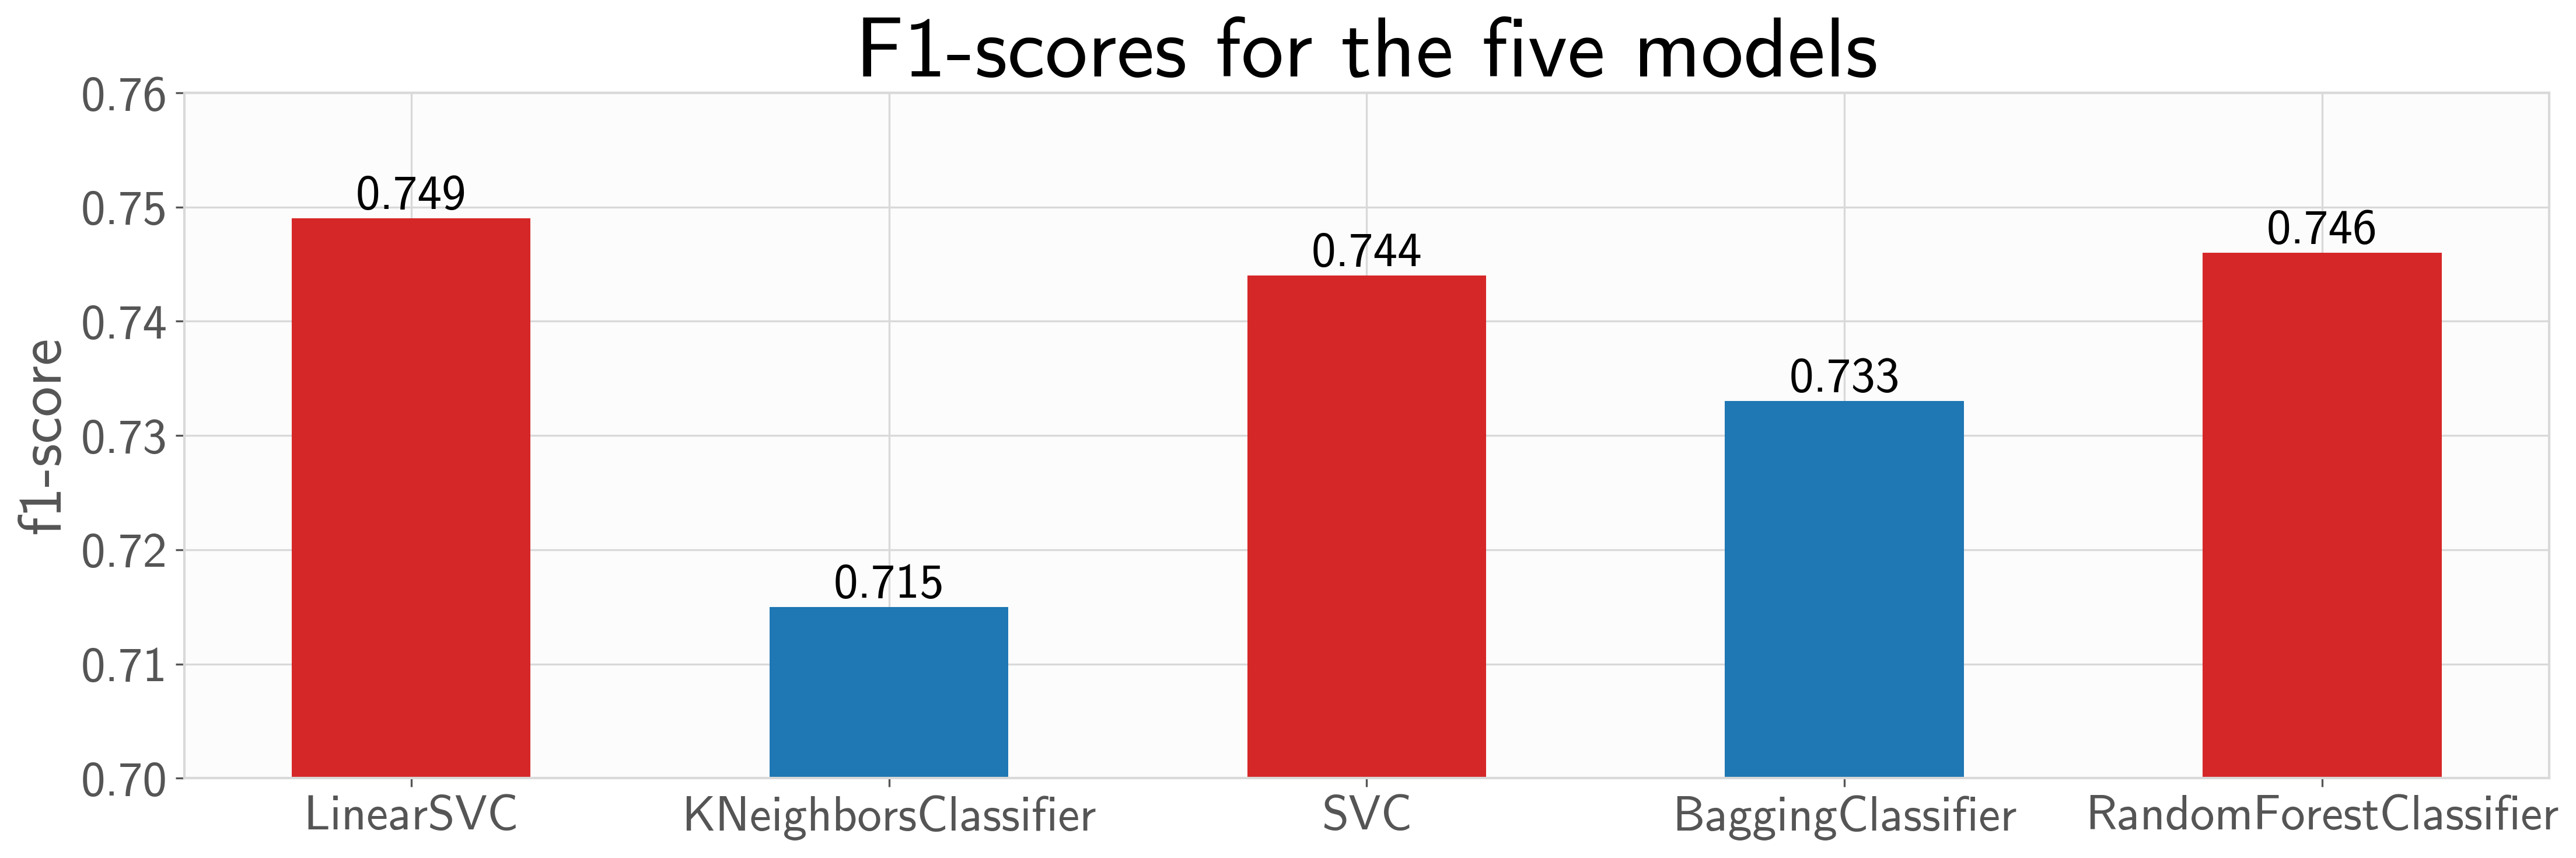

In [22]:
import matplotlib.pyplot as plt
import matplotlib

#%% Plotting options ---------------------------------------------
#Set up plot parameters
color_bg      = "0.99"          #Choose background color
color_gridaxe = "0.85"          #Choose grid and spine color
rc = {"axes.edgecolor":color_gridaxe} 
plt.style.use(('ggplot', rc))           #Set style with extra spines
plt.rcParams['figure.dpi'] = 300        #Set resolution
plt.rcParams["figure.figsize"] = (15, 5) #Set figure size
matplotlib.rcParams['font.family'] = ['cmss10']     #Change font to Computer Modern Sans Serif
plt.rcParams['axes.unicode_minus'] = False          #Re-enable minus signs on axes))
plt.rcParams['axes.facecolor']= "0.99"              #Set plot background color
plt.rcParams.update({"axes.grid" : True, "grid.color": color_gridaxe}) #Set grid color
plt.rcParams['axes.grid'] = True

# Data -------------------------------------------------------------
y = [0.749,0.715,0.744,0.733,0.746]
x = ['LinearSVC','KNeighborsClassifier','SVC','BaggingClassifier','RandomForestClassifier']


fig, ax = plt.subplots()
bars = ax.bar(x, y, width = 0.5,color=('tab:red','tab:blue','tab:red','tab:blue','tab:red'))


#ax.bar_label(bars)

for bars in ax.containers:
    ax.bar_label(bars,fontsize=20)
    
plt.title('F1-scores for the five models',fontsize=35)
plt.ylim([0.7,0.76])
plt.ylabel('f1-score', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tight_layout()

plt.savefig('f1_score_comp', dpi = 300)